# Crystal Calc
A collection of tools to make an engineer's life easier
## Setup

In [4]:
import numpy as np
import matplotlib.pyplot as plt

parallel = lambda a,b : (a*b)/(a+b)
Fs  = lambda cm,lm       : 1 / (2 * np.pi * np.sqrt(lm * cm))
Fa  = lambda fs,c0,cm    : fs * np.sqrt(1 + cm / c0)
Ts  = lambda cm,c0,cl    : -( cm / ( 2 * ( c0 + cl )**2 ) )*1e-6
Q   = lambda rm,lm,cm    : (1 / rm) * np.sqrt(lm / cm)
Esr = lambda rm,c0,cl    : rm * (1 + c0 / cl)**2

def Fl(fs,c0,cm,cl):
    """
    Calculates the crystal frequency given a load and
    the its equivalent spice parameters.

    Parameters:
        fs : Series resonant frequency in Hz
        c0 : Shunt capacitance usually in pF (ex. 1.2e-12)
        cm : Motional capacitance also known as c1 
             usually in fF (ex. 2.4e-15)
        cl : Plating load usually specified in the datasheet
             usually in pF (ex. AB07-120-32.768kHz is 6pF == 6e-12)

    Returns:
        fl : The calculated crystal frequency
        
    """
    return fs * (1 + cm / (2 * (c0 + cl)))

def power_predict(rm, fl, cl, c0, vout_peak):
    """
    Predicts the drive level of an oscillator configuration 
    based on the Intel App Note AP-155.
    
    Parameters:
        rm : Motional resistance (approximately ESR)
        fl : Crystal resonant frequency in Hz
        cl : Approximate plating load the crystal sees
        c0 : Shunt capacitance of the crystal usually
             in pF (ex. 1.2e-12)
        vout_peak : This is the peak voltage seen on the output
                    of the oscillator usually marked as xtal_out
                    in the IC datasheet
                    
    Returns:
        A power prediction in watts.
    """
    return 2 * rm * (np.pi * fl * (cl + c0) * vout_peak)**2

def find_cl(fs,c1,c0,fl):
    """Determines the plating load apparent to the crystal"""
    return -c0 + c1 / (2 * (-1 + fl/fs))

def hz2ppm(f, fnom):
    """Convertst a frequency deviation to ppm"""
    return (f - fnom) * 1e6 / fnom

def ppm2hz(ppm, f_nominal_hz):
    """Converts ppm to Hz"""
    return f_nominal_hz + ppm * f_nominal_hz / 1e6

def rms(peak2peak):
    """Calculates the rms value of the peak-to-peak measurement."""
    return peak2peak / (2 * np.sqrt(2))

def Z(f,rm,cm,lm,c0):
    """Determines the impedance of a crystal at a certain frequency.""" 
    w = 2 * np.pi * f
    return  parallel((rm + 1/(cm*w) + lm*w) , (1/(c0*2)))

def analyze(rm,cm,lm,c0,cl):
    """"
    Displays the magnitude and phase response of a crystal
    ~~ Not working at the moment ~~
    """
    fs = Fs(cm,lm)
    fa = Fa(fs,c0,cm)
    fl = Fl(fs,c0,cm,cl)
    q  = Q (rm,lm,cm)
    
    print(f"fs = {fs}")
    print(f"fa = {fa}")
    print(f"fl = {fl}")
    print(f"q  = {q }")
    
    # Frequency sweep range calc
    sweepstart = fs - 0.5*(fa-fs)
    sweepend   = fa + 0.5*(fa-fs)
    sweeprange = np.linspace(sweepstart, sweepend, 100000)
    print(f"sweep range = [{sweepstart},{sweepend}]")
    z = Z(sweeprange,rm,cm,lm,c0)
    mag = np.abs(z)
    phase = np.angle(z)
    
#     plt.plot(sweeprange, mag, label='magnitude')
#     plt.plot(sweeprange, phase, label='phase')
#     plt.legend()

## Scrapbook

In [2]:
fl = ppm2hz(2.41, 32768)
fs = 32755.2452844868
rm = 44213.21
rm_max = 45e3
cm = 6.67597348377331e-15
c0 = 1.5194505369094e-12
fmeas = 32766.24
vout_peak = 0.4249 * np.sqrt(2)
vin_peak  = 0.1852 * np.sqrt(2)
cl_recommended = 7.03e-12
fcur = hz2ppm(fmeas, 32768)
measured_load = find_cl(fs, cm, c0, fmeas)

pnw = power_predict(rm, fl, measured_load, c0, vout_peak) * 1e9
pnw_max = power_predict(rm_max, fl, measured_load, c0, vout_peak) * 1e9

fl_recommended = Fl(fs, c0, cm, cl_recommended)
fl_ppm_recommended = hz2ppm(fl_recommended, 32768)
cl_recommended = find_cl(fs, cm, c0, fl_recommended)
pnw_recommended = power_predict(rm, fl_recommended, cl_recommended, c0, vout_peak) * 1e9
pnw_max_recommended = power_predict(rm_max, fl_recommended, cl_recommended, c0, vout_peak) * 1e9

print("Current config")
print(f"F Current  = {fcur:.2f}Hz")
print(f"Nominal DL = {pnw:.2f}nW")
print(f"Max DL     = {pnw_max:.2f}nW")
print(f"\nWorst Case")
print(f"F Current  = {fl_ppm_recommended:.2f}ppm")
print(f"Nominal DL = {pnw_recommended:.2f}nW")
print(f"Max DL     = {pnw_max_recommended:.2f}nW")

Current config
F Current  = -53.71Hz
Nominal DL = 33.46nW
Max DL     = 34.06nW

Worst Case
F Current  = 1.04ppm
Nominal DL = 24.73nW
Max DL     = 25.17nW


## Load to Freq Prediction

In [3]:
fnom = 32768
fs = None
c0 = 1.11226379050365e-12
cm = 4.3243121440552e-15
cl = 4e-12
cl_predict = 3.75e-12
lm = 5460.03575083361
rm = 0
fs = Fs(cm, lm) 

fl = Fl(fs, c0, cm, cl)
ppm = hz2ppm(fl, fnom)
fl_predict = Fl(fs, c0, cm, cl_predict)
ppm_predict = hz2ppm(fl_predict, fnom)

print(f"FL:  {fl:.2f}\tppm:  {ppm:.2f}\t@ {cl*1e12:.2f}pF")
print(f"FL:  {fl_predict:.2f}\tppm:  {ppm_predict:.2f}\t@ {cl_predict*1e12:.2f}pF")
print(f"ΔFL: {fl_predict - fl:.2f}\tΔppm: {ppm_predict - ppm:.2f}")
print(f"Ts:  {Ts(cm,c0,cl):.2f}ppm/pF ")

FL:  32767.82	ppm:  -5.58	@ 4.00pF
FL:  32768.53	ppm:  16.15	@ 3.75pF
ΔFL: 0.71	Δppm: 21.74
Ts:  -82.73ppm/pF 


## Drive Level Estimation

In [4]:
# Crystal parameters
rm = 48214.91
c0 = 1.3429e-12
cl = 2e-12 # Estimate

# Current probe parameters
Vcspp = 180.07e-3
v2i = 1/5

esr  = Esr(rm,c0,cl)
i    = Vcspp * v2i
irms = rms(i)
p    = esr * irms**2

print(f"Rm   = {rm:.2f}Ω")
print(f"C0   = {c0 * 1e12:.2f}pF")
print(f"CL   = {cl * 1e12:.2f}pF")
print(f"ESR  = {esr:.2f}Ω")
print(f"Ipp  = {i*1e3:.2f}mA")
print(f"Irms = {irms*1e3:.2f}mA")
print(f"Prms = {p*1e6:.2f}uW")

Rm   = 48214.91Ω
C0   = 1.34pF
CL   = 2.00pF
ESR  = 134700.17Ω
Ipp  = 36.01mA
Irms = 12.73mA
Prms = 21838402.85uW


# Plotting

fs = 32753.964260242337
fa = 32806.65788045124
fl = 32775.14921423685
q  = 23305.469964983185
sweep range = [32727.617450137885,32833.00469055569]
FL ppm = 19.0625


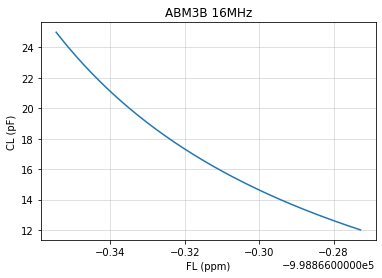

In [7]:
analyze(rm,cm,lm,c0,cl)
clsweep = np.linspace(12e-12,25e-12, 1000)
fl = Fl(fs, c0, cm, clsweep)
ppm = hz2ppm(fl, 32e6)
plt.plot(ppm+110, clsweep*1e12)
plt.xlabel('FL (ppm)')
plt.ylabel('CL (pF)')
plt.title('ABM3B 16MHz')
plt.grid(alpha=0.5)

print(f"FL ppm = {hz2ppm(32000610, 32e6)}")